### Notebook to analyse the results for the different models as collected in a results folder

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import re
from tqdm.notebook import tqdm

# set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

#### To load intermediate results from docs folder:

In [2]:
def load_results_metrics(root_dir: str, pattern: str = "results_with_cells_*.json") -> pd.DataFrame:
    """
    Scan the given root_dir (e.g., "../docs/results") for intermediate results files
    (named like "results_with_cells_{model_name}_{dataset_basename}_{N}_{learning_type}_{format_type}.json"),
    compute metrics (precision, recall, f1, accuracy, TP, FP, TN, FN) from each file,
    and return a DataFrame with one row per results file.
    """
    all_metrics = []
    
    # Use glob to find all matching files
    file_list = glob.glob(os.path.join(root_dir, pattern))
    if not file_list:
        print("No intermediate results files found matching pattern.")
        return pd.DataFrame()
    
    # Define a regex pattern to extract configuration info from the filename.
    # (Assumes names like: results_with_cells_{model_name}_{dataset_basename}_{N}_{learning_type}_{format_type}.json)
    filename_regex = re.compile(
        r"^results_with_cells_(?P<model_name>[^_]+)_" +                # model_name: no underscores assumed
        r"(?P<dataset_basename>.+?)_" +                                # dataset_basename: non-greedy
        r"(?P<N>\d+)_" +                                              # N: one or more digits
        r"(?P<learning_type>.+?)(?=_[^_]+\.json$)_" +                   # learning_type: non-greedy until underscore + format_type
        r"(?P<format_type>[^_]+)\.json$"                                # format_type: no underscores expected
    )
    
    for file_path in tqdm(file_list):
        try:
            with open(file_path, "r") as f:
                results = json.load(f)
        except Exception as e:
            print(f"Could not load {file_path}: {e}")
            continue

        # From your results, build y_true and y_pred lists.
        y_true = [r["true_response"] for r in results if r.get("predicted_response") is not None]
        y_pred = [r["predicted_response"] for r in results if r.get("predicted_response") is not None]
        
        if len(y_true) == 0:
            print(f"No valid predictions in {file_path}.")
            continue

        # Compute metrics (using zero_division=0 so that a zero denominator returns 0)
        try:
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            accuracy = accuracy_score(y_true, y_pred)
            cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
            else:
                tn = fp = fn = tp = 0
        except Exception as e:
            print(f"Error computing metrics for {file_path}: {e}")
            continue
        
        # Extract configuration info from the filename
        base_name = os.path.basename(file_path)
        m = filename_regex.match(base_name)
        if m:
            model_name = m.group("model_name")
            dataset_basename = m.group("dataset_basename")
            N_val = m.group("N")
            learning_type = m.group("learning_type")
            format_type = m.group("format_type")
        else:
            # If filename doesn't match, set as unknown.
            model_name = dataset_basename = N_val = learning_type = format_type = "UNKNOWN"
        
        metrics_dict = {
            "model_name": model_name,
            "dataset_type": dataset_basename,
            "learning_type": learning_type,
            "format_type": format_type,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "accuracy": accuracy,
            "true_positives": tp,
            "false_positives": fp,
            "true_negatives": tn,
            "false_negatives": fn,
            "n_tables": N_val,
            "n_claims": len(y_true),
            "result_file": base_name
        }
        all_metrics.append(metrics_dict)
    
    if not all_metrics:
        print("No metrics computed from the intermediate results.")
        return pd.DataFrame()
    
    return pd.DataFrame(all_metrics)

In [3]:
docs_results_folder = "../docs/results"
    
print("\nLoading intermediate results files and computing metrics ...")
df_stats = load_results_metrics(docs_results_folder, pattern="results_with_cells_*.json")
if not df_stats.empty:
    # Optionally, you can set categorical ordering if desired:
    learning_type_order = ["zero_shot", "chain_of_thought"] #, "one_shot", "few_shot", "chain_of_thought"]
    df_stats["learning_type"] = pd.Categorical(df_stats["learning_type"], categories=learning_type_order, ordered=True)

    format_type_order = ["json", "html", "naturalized", "markdown"]
    df_stats["format_type"] = pd.Categorical(df_stats["format_type"], categories=format_type_order, ordered=True)

    print("Intermediate Results Metrics DataFrame (one row per results file):")
    display(df_stats)

    # For example, group by (model_name, dataset_type, learning_type, format_type) and compute the mean metrics:
    grouped = df_stats.groupby(["model_name", "dataset_type", "learning_type", "format_type"])[
        ["precision", "recall", "f1_score", "accuracy", "true_positives", "false_positives", "true_negatives", "false_negatives"]
    ].mean()
    print("\nMean metrics by (model_name, dataset_type, learning_type, format_type):")
    display(grouped)
else:
    print("No intermediate result metrics data found.")


Loading intermediate results files and computing metrics ...


  0%|          | 0/32 [00:00<?, ?it/s]

Intermediate Results Metrics DataFrame (one row per results file):


,model_name,dataset_type,learning_type,format_type,precision,recall,f1_score,accuracy,true_positives,false_positives,true_negatives,false_negatives,n_tables,n_claims,result_file
0,llama3.2:latest,test_examples,zero_shot,html,0.609175,0.378210,0.466679,0.565381,2430,1559,4795,3995,1695,12779,results_with_cells_llama3.2:latest_test_exampl...
1,llama3.2:latest,test_examples,zero_shot,naturalized,0.644498,0.375564,0.474580,0.581892,2413,1331,5023,4012,1695,12779,results_with_cells_llama3.2:latest_test_exampl...
2,llama3.2:latest,test_examples,zero_shot,json,0.601286,0.349261,0.441863,0.556382,2244,1488,4866,4181,1695,12779,results_with_cells_llama3.2:latest_test_exampl...
3,llama3.2:latest,test_examples,zero_shot,markdown,0.631727,0.453074,0.527690,0.592222,2911,1697,4657,3514,1695,12779,results_with_cells_llama3.2:latest_test_exampl...
4,mistral:latest,test_examples,zero_shot,json,0.684735,0.491518,0.572257,0.630566,3158,1454,4900,3267,1695,12779,results_with_cells_mistral:latest_test_example...
5,mistral:latest,test_examples,zero_shot,naturalized,0.718471,0.400778,0.514537,0.619767,2575,1009,5345,3850,1695,12779,results_with_cells_mistral:latest_test_example...
6,mistral:latest,test_examples,zero_shot,html,0.712159,0.439377,0.543459,0.628844,2823,1141,5213,3602,1695,12779,results_with_cells_mistral:latest_test_example...
7,mistral:latest,test_examples,zero_shot,markdown,0.696780,0.468171,0.560045,0.630175,3008,1309,5045,3417,1695,12779,results_with_cells_mistral:latest_test_example...
8,deepseek-r1:8b,test_examples,zero_shot,html,0.844378,0.694467,0.762121,0.782194,4205,775,5222,1850,1551,12052,results_with_cells_deepseek-r1:8b_test_example...
9,deepseek-r1:8b,test_examples,zero_shot,markdown,0.884630,0.752316,0.813126,0.826297,4547,593,5395,1497,1545,12032,results_with_cells_deepseek-r1:8b_test_example...



Mean metrics by (model_name, dataset_type, learning_type, format_type):


/tmp/ipykernel_1569708/96232483.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_stats.groupby(["model_name", "dataset_type", "learning_type", "format_type"])[


precision  \
model_name      dataset_type  learning_type    format_type              
deepseek-r1:32b test_examples zero_shot        json          0.902710   
                                               html          0.886463   
                                               naturalized   0.920708   
                                               markdown      0.907066   
                              chain_of_thought json               NaN   
                                               html               NaN   
                                               naturalized        NaN   
                                               markdown           NaN   
deepseek-r1:8b  test_examples zero_shot        json          0.863861   
                                               html          0.844378   
                                               naturalized   0.885378   
                                               markdown      0.884630   
                              chain_of_thought json               NaN   
                                               html               NaN   
                                               naturalized        NaN   
                                               markdown           NaN   
llama3.2:latest test_examples zero_shot        json          0.601286   
                                               html          0.609175   
                                               naturalized   0.644498   
                                               markdown      0.631727   
                              chain_of_thought json          0.517413   
                                               html          0.580600   
                                               naturalized   0.620813   
                                               markdown      0.621538   
mistral:latest  test_examples zero_shot        json          0.684735   
                                               html          0.712159   
                                               naturalized   0.718471   
                                               markdown      0.696780   
                              chain_of_thought json          0.588959   
                                               html          0.595187   
                                               naturalized   0.606736   
                                               markdown      0.604612   
phi4:latest     test_examples zero_shot        json          0.885848   
                                               html          0.885389   
                                               naturalized   0.909195   
                                               markdown      0.905836   
                              chain_of_thought json          0.860520   
                                               html          0.867037   
                                               naturalized   0.897361   
                                               markdown      0.892892   

                                                              recall  \
model_name      dataset_type  learning_type    format_type             
deepseek-r1:32b test_examples zero_shot        json         0.720866   
                                               html         0.689304   
                                               naturalized  0.779689   
                                               markdown     0.786424   
                              chain_of_thought json              NaN   
                                               html              NaN   
                                               naturalized       NaN   
                                               markdown          NaN   
deepseek-r1:8b  test_examples zero_shot        json         0.700334   
                                               html         0.694467   
                                               naturalized  0.775213   
                                               markdown  

#### To load final results:

In [2]:
def load_summary_stats(root_dir: str, filename_pattern: str = "summary_stats.json") -> pd.DataFrame:
    """
    Recursively scan `root_dir` for JSON files matching `filename_pattern` (e.g. 'summary_stats.json'),
    load them, and return a concatenated DataFrame with all fields.
    """
    all_data = []
    
    # Walk through all subfolders and look for JSON files named 'summary_stats.json'
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file == filename_pattern:
                file_path = os.path.join(subdir, file)
                try:
                    with open(file_path, "r") as f:
                        data = json.load(f)
                    # Optionally add the file path or subdir for reference:
                    data["file_path"] = file_path
                    data["directory"] = os.path.basename(subdir)
                    all_data.append(data)
                except Exception as e:
                    print(f"Could not load {file_path}: {e}")
    
    # Convert the list of dicts to a DataFrame
    if not all_data:
        print("No matching JSON files found.")
        return pd.DataFrame()
    df = pd.DataFrame(all_data)
    return df

In [3]:
results_folder = "results_20250203"

df_stats = load_summary_stats(results_folder, filename_pattern="summary_stats.json")
# display(df_stats)
if not df_stats.empty:
    # print("DataFrame with all summary stats:")
    # display(df_stats)

    learning_type_order = ["zero_shot"] #, "one_shot", "few_shot"]
    df_stats["learning_type"] = pd.Categorical(df_stats["learning_type"], categories=learning_type_order, ordered=True)

    format_type_order = ["json", "html", "naturalized", "markdown"]
    df_stats["format_type"] = pd.Categorical(df_stats["format_type"], categories=format_type_order, ordered=True)

    # Group metrics by (model_name, learning_type, dataset_type)
    grouped = df_stats.groupby(["model_name", "dataset_type", "learning_type", "format_type"])[
        ["precision", "recall", "f1_score", "accuracy", "true_positives", "false_positives", "true_negatives", "false_negatives"]
    ].mean()
    print("Mean metrics by (model_name, learning_type, dataset_type):")
    display(grouped)
else:
    print("No data to analyze or plot.")

No matching JSON files found.
No data to analyze or plot.


### Visualization of results

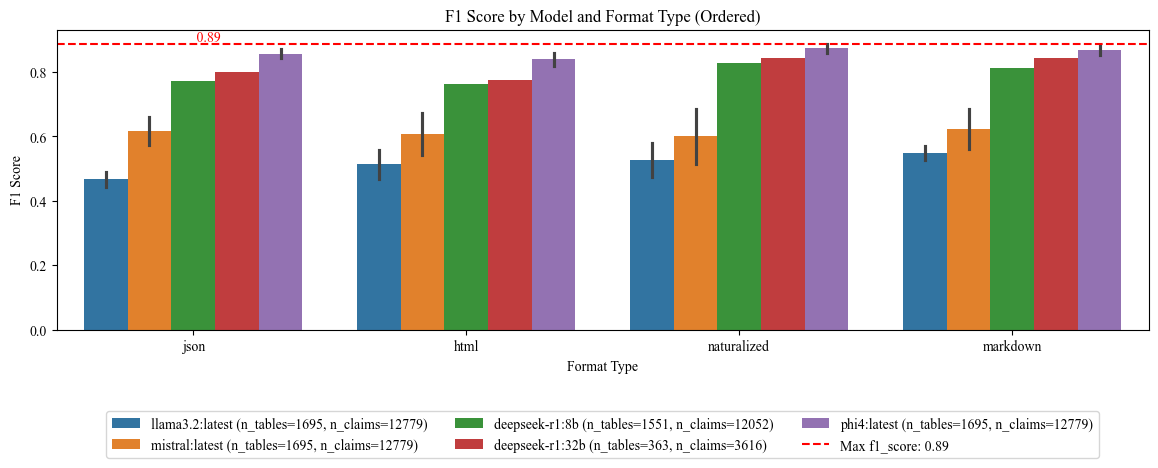

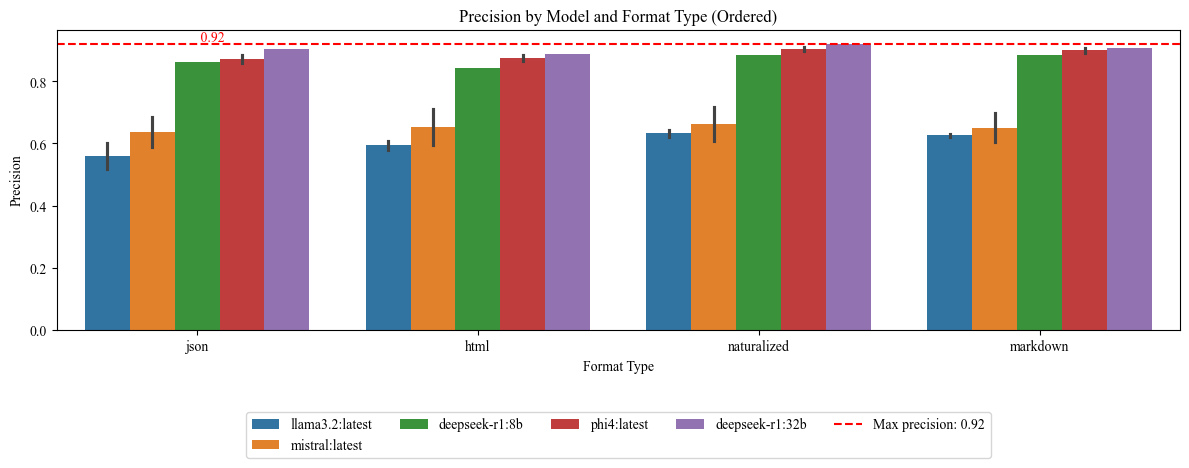

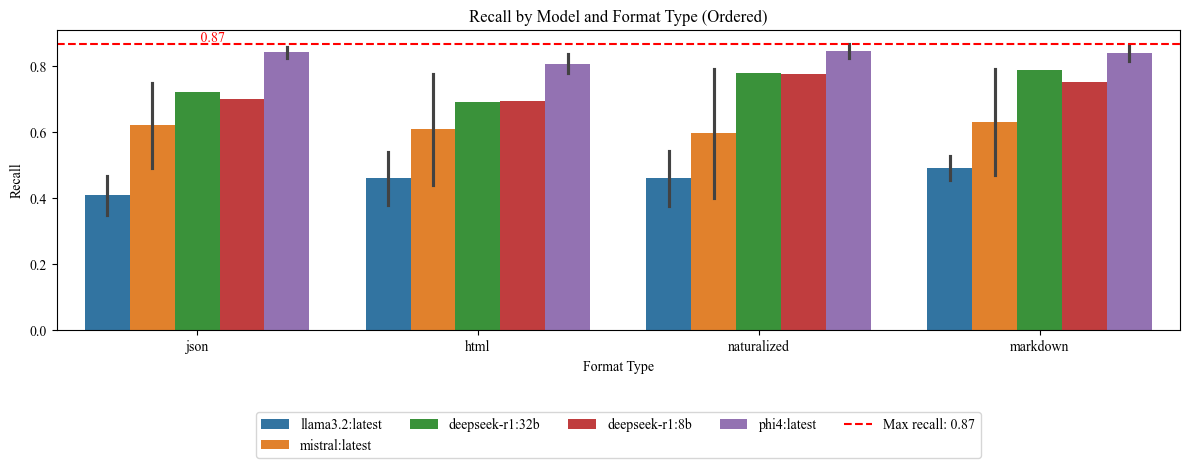

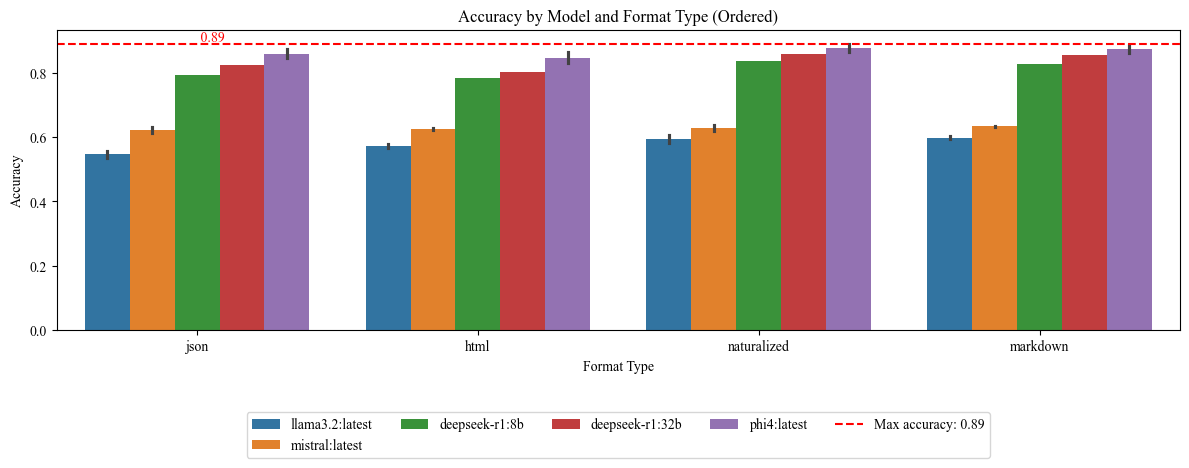

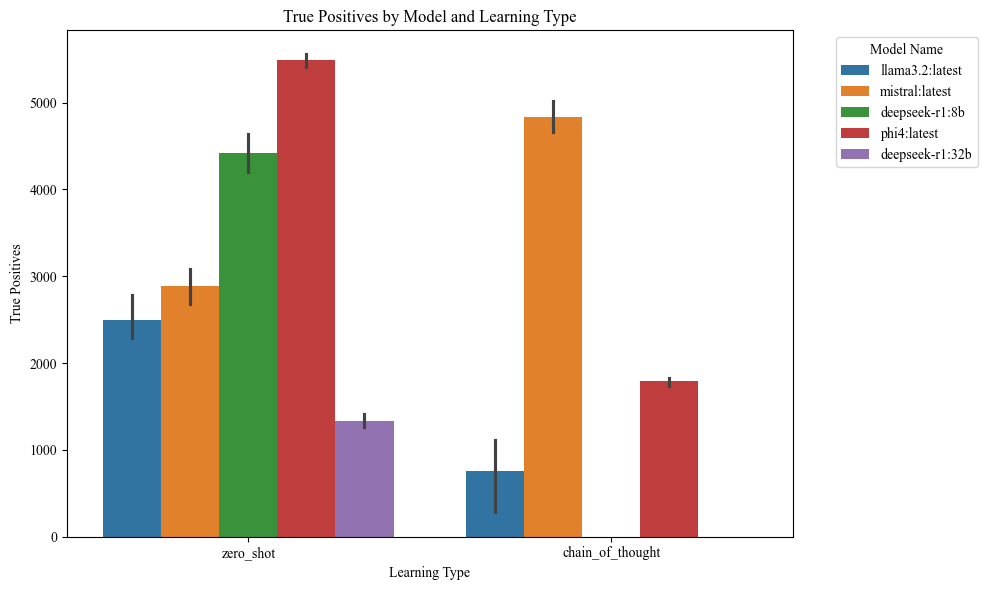

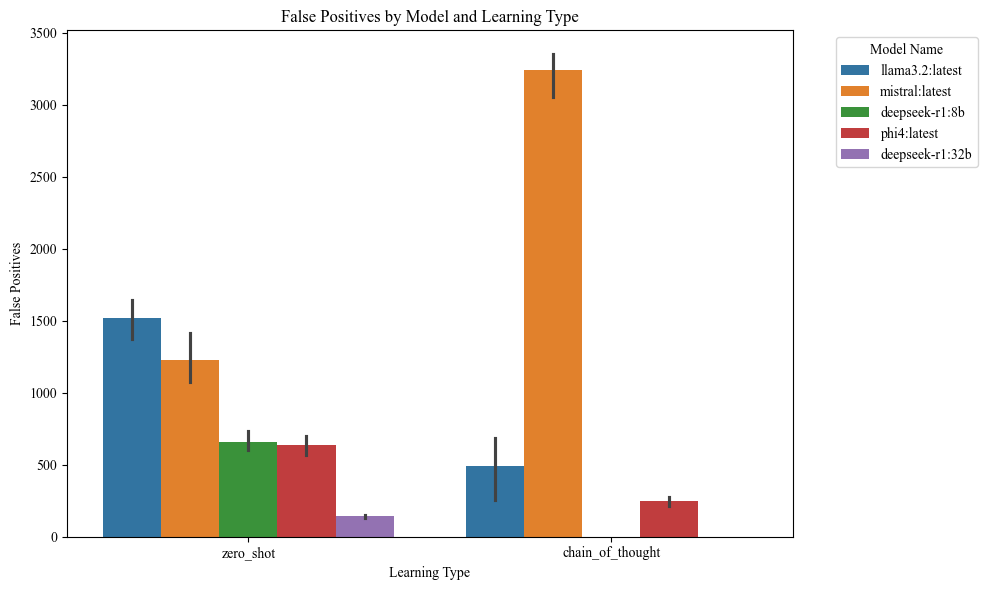

In [6]:
metrics_to_sort = ["f1_score", "precision", "recall", "accuracy"]
sorted_dfs = {
    metric: df_stats.sort_values(by=metric, ascending=True)
    for metric in metrics_to_sort
}

def plot_metric_bar(metric, title, xlabel, ylabel, sorted_data, figsize=(12, 5), stats_df=None):
    """
    Plot a bar chart for a given metric and annotate the highest value.
    
    Parameters:
      - metric: the metric column name to plot (e.g., "f1_score")
      - title: plot title
      - xlabel: x-axis label
      - ylabel: y-axis label
      - sorted_data: the DataFrame to use for plotting
      - figsize: figure size (default is (10,4) for LaTeX compatibility)
      - stats_df: optional DataFrame that contains 'n_tables' per model; if provided,
                  the legend labels will be updated to include the number of results.
    """
    plt.figure(figsize=figsize)
    
    # Create the barplot
    ax = sns.barplot(
        data=sorted_data,
        x="format_type",
        y=metric,
        hue="model_name",
        order=format_type_order,  # enforce a fixed order for format types
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Annotate with a horizontal line at the max value of the metric
    max_val = sorted_data[metric].max()
    plt.axhline(max_val, color='red', linestyle='--', label=f'Max {metric}: {max_val:.2f}')
    # Optionally, place a text annotation at the left side of the plot:
    plt.text(0, max_val, f' {max_val:.2f}', color='red', va='bottom', ha='left')
    
    # Update the legend if stats_df with 'n_tables' and 'n_claims" is available
    if stats_df is not None and 'n_tables' in stats_df.columns and 'n_claims' in stats_df.columns:
        handles, labels = ax.get_legend_handles_labels()
        new_labels = []
        # For each unique model in the current plot, try to fetch its n_tables value.
        for label in labels:
            # Here we assume that stats_df has one row per model (or that you can select one,
            # e.g., via aggregation, if there are several rows per model).
            n_tab_series = stats_df.loc[stats_df['model_name'] == label, 'n_tables']
            n_claims_series = stats_df.loc[stats_df['model_name'] == label, 'n_claims']
            if not n_tab_series.empty and not n_claims_series.empty:
                # For example, take the first value (or you could use sum, mean, etc.)
                n_tab_val = n_tab_series.iloc[0]
                n_claims_val = n_claims_series.iloc[0]
                new_label = f"{label} (n_tables={n_tab_val}, n_claims={n_claims_val})"
            else:
                new_label = label
            new_labels.append(new_label)
        plt.legend(handles, new_labels, loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=3)
    else:
        # Use the default legend if no n_tables info is available.
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=5)
    
    plt.tight_layout()
    plt.show()



# Visualization: F1 Score
plot_metric_bar(
    metric="f1_score",
    title="F1 Score by Model and Format Type (Ordered)",
    xlabel="Format Type",
    ylabel="F1 Score",
    sorted_data=sorted_dfs["f1_score"],
    stats_df=df_stats  # assuming df_stats has a column named 'n_tables'
)

# Visualization: Precision
plot_metric_bar(
    metric="precision",
    title="Precision by Model and Format Type (Ordered)",
    xlabel="Format Type",
    ylabel="Precision",
    sorted_data=sorted_dfs["precision"],
)

# Visualization: Recall
plot_metric_bar(
    metric="recall",
    title="Recall by Model and Format Type (Ordered)",
    xlabel="Format Type",
    ylabel="Recall",
    sorted_data=sorted_dfs["recall"],
)

# Visualization: Accuracy
plot_metric_bar(
    metric="accuracy",
    title="Accuracy by Model and Format Type (Ordered)",
    xlabel="Format Type",
    ylabel="Accuracy",
    sorted_data=sorted_dfs["accuracy"],
)

# Plot Confusion Matrix components
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_stats,
    x="learning_type",
    y="true_positives",
    hue="model_name",
    order=df_stats["learning_type"].unique(),
)
plt.title("True Positives by Model and Learning Type")
plt.xlabel("Learning Type")
plt.ylabel("True Positives")
plt.legend(title="Model Name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_stats,
    x="learning_type",
    y="false_positives",
    hue="model_name",
    order=df_stats["learning_type"].unique(),
)
plt.title("False Positives by Model and Learning Type")
plt.xlabel("Learning Type")
plt.ylabel("False Positives")
plt.legend(title="Model Name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

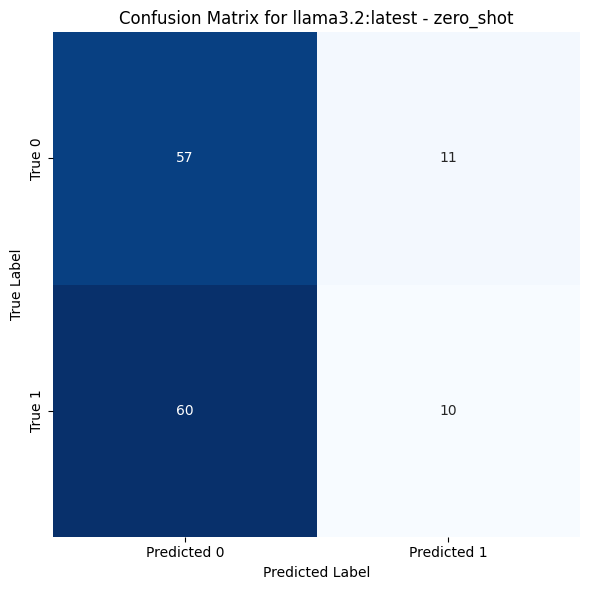

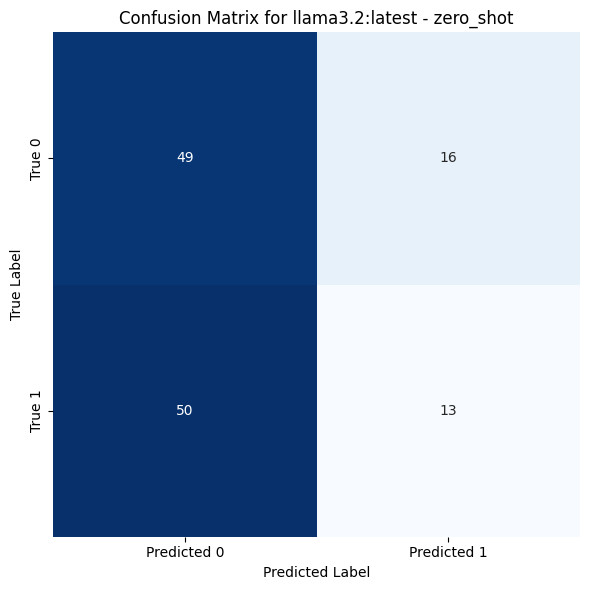

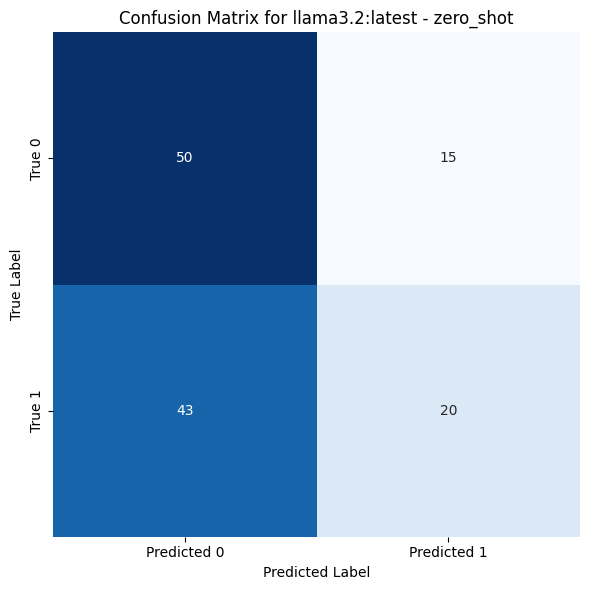

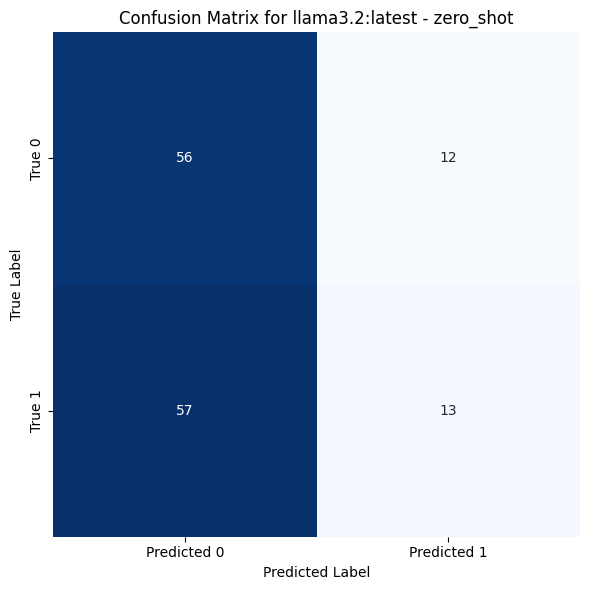

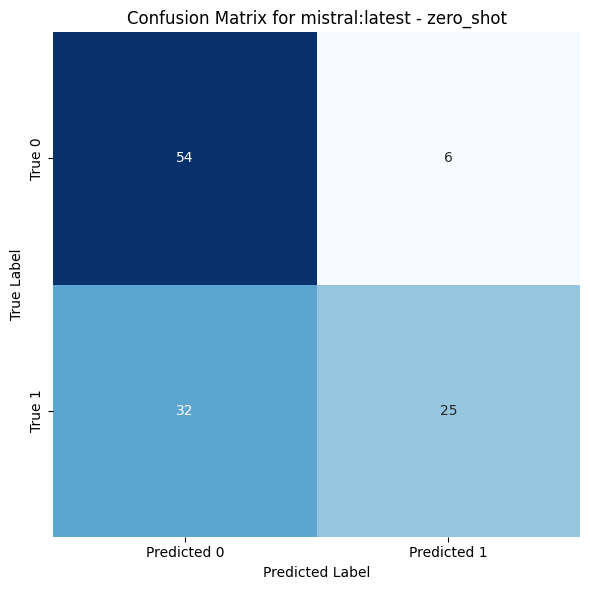

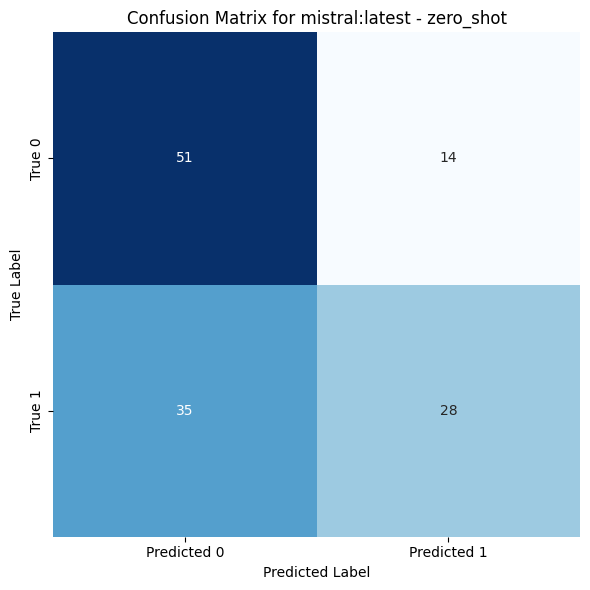

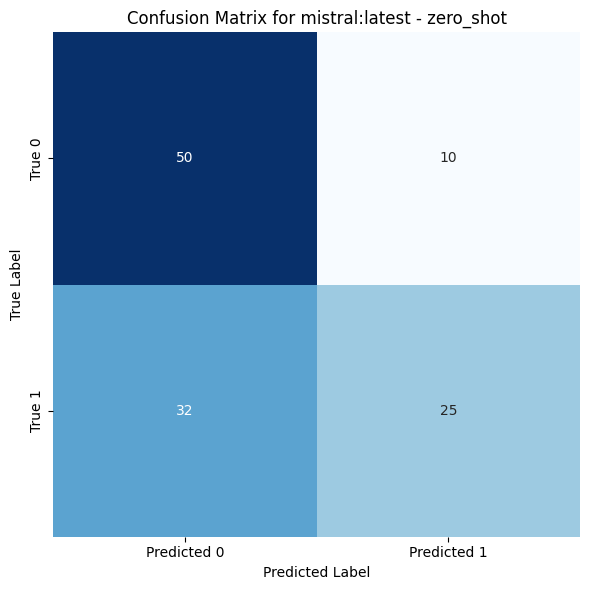

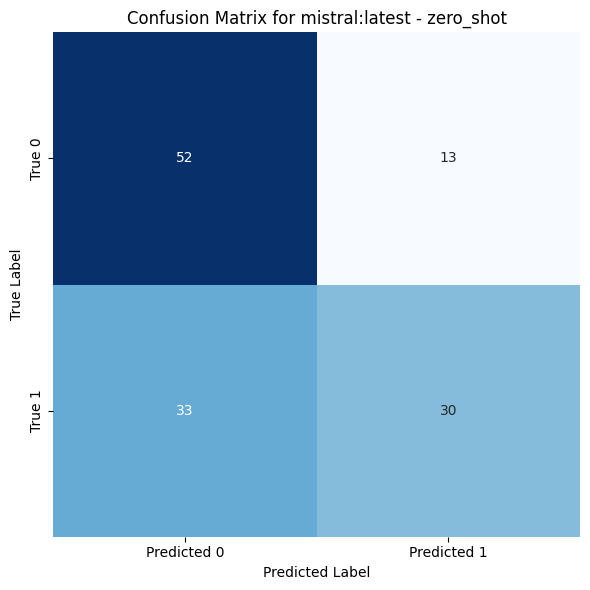

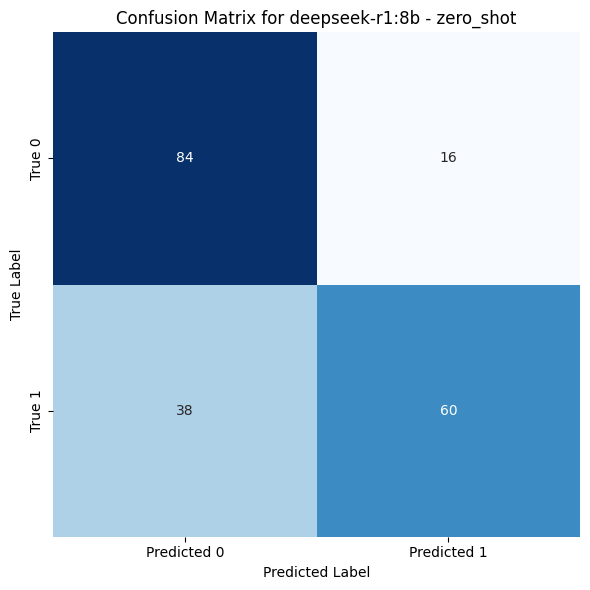

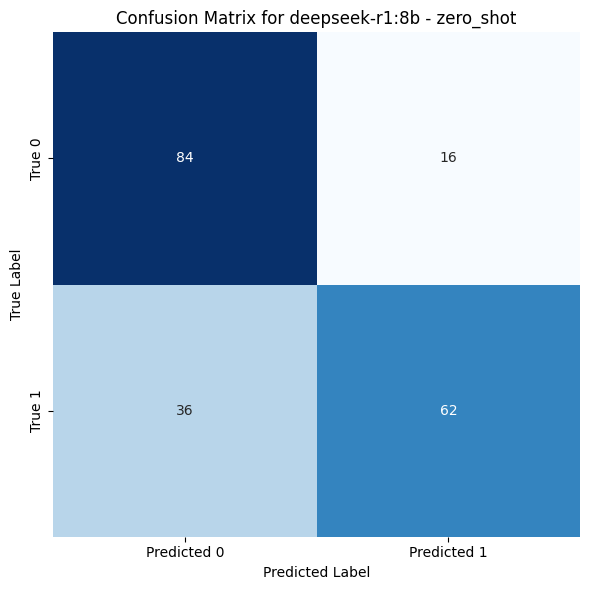

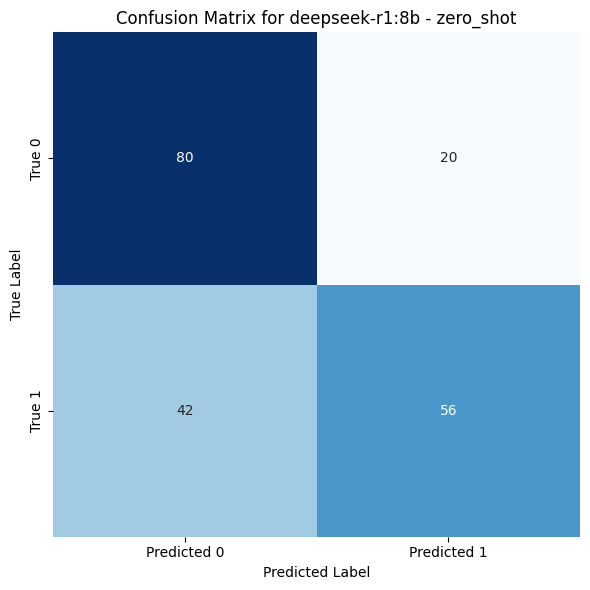

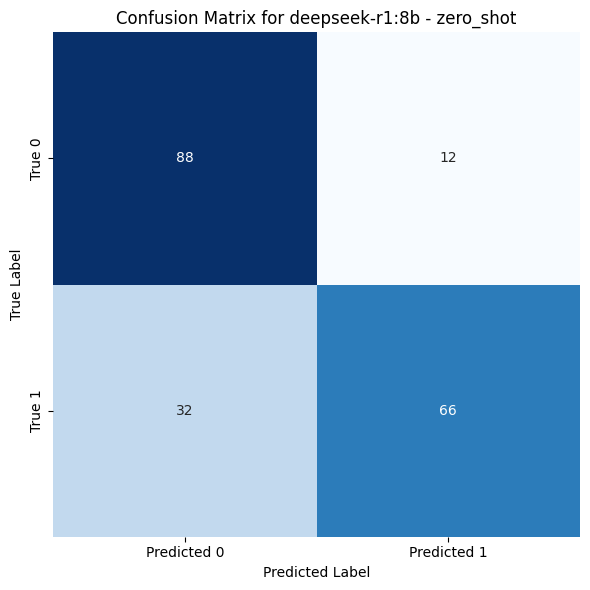

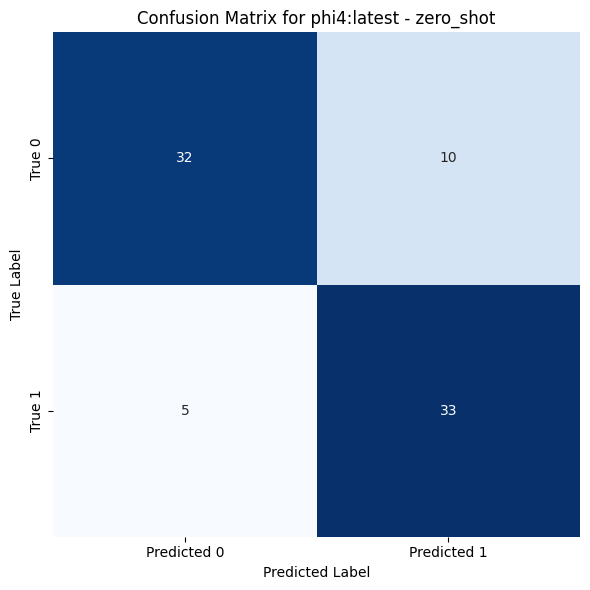

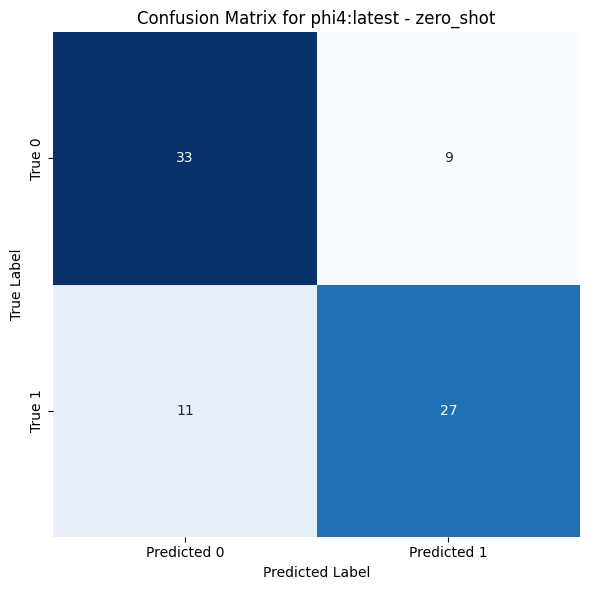

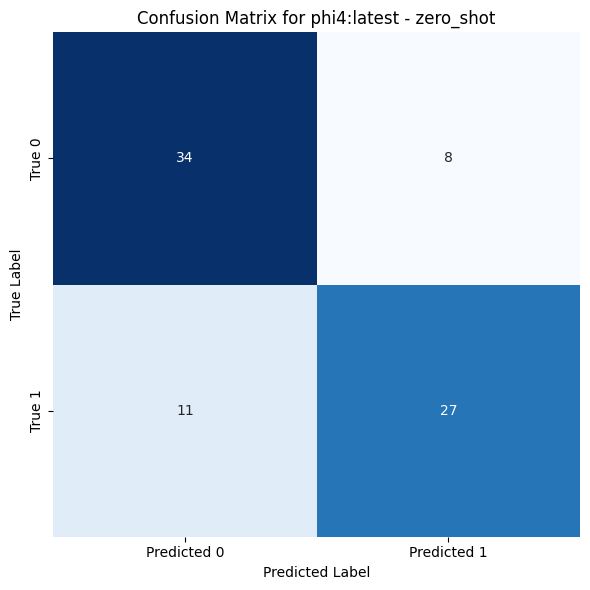

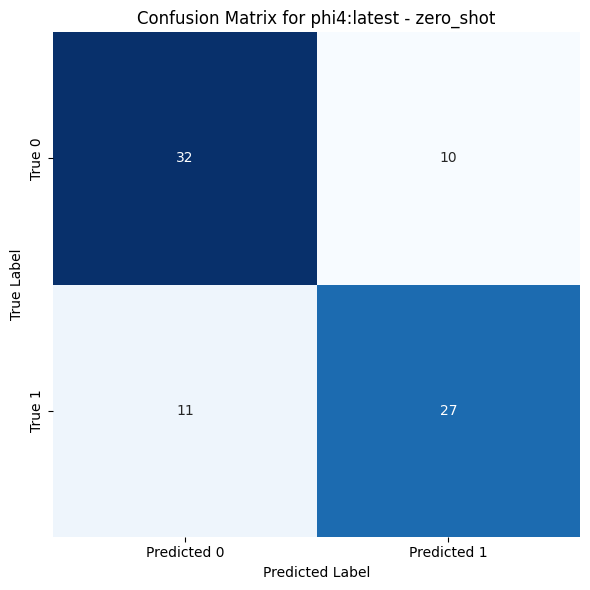

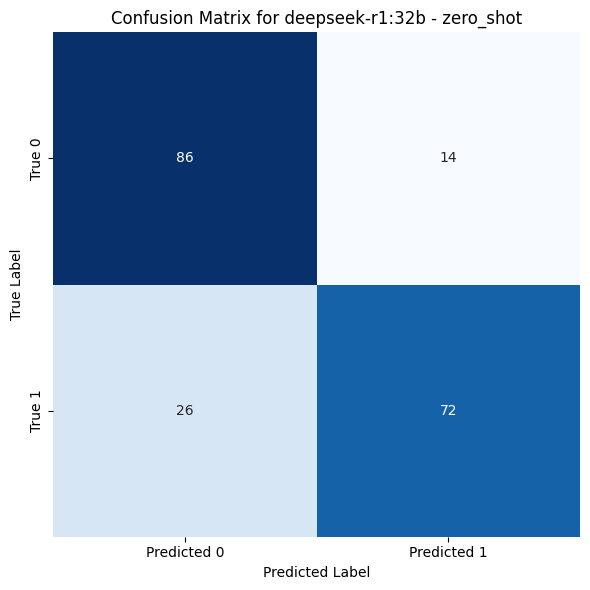

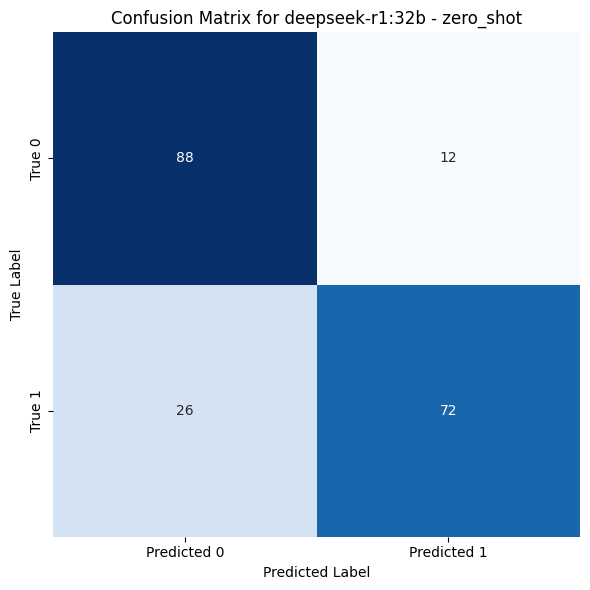

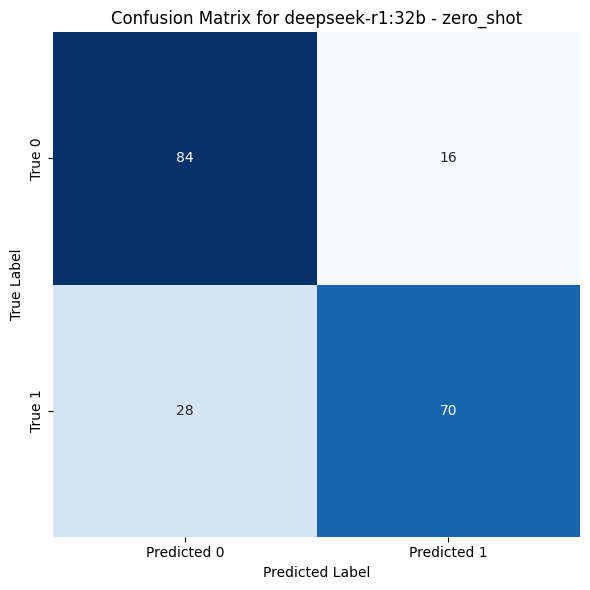

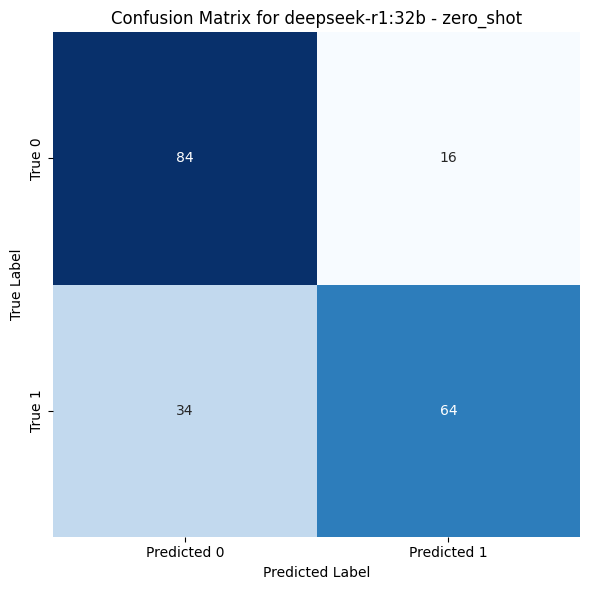

In [6]:
# Plot Confusion Matrices
def plot_confusion_matrix(row, title, figsize=(6, 6)):
    """
    Plot a single confusion matrix from a row in the DataFrame.

    Args:
        row (pd.Series): A single row of the DataFrame containing confusion matrix components.
        title (str): Title of the plot.
        figsize (tuple): Size of the plot.
    """
    cm = np.array(row["confusion_matrix"])
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Generate confusion matrices for each (model_name, learning_type)
for _, row in df_stats.iterrows():
    plot_confusion_matrix(
        row,
        title=f"Confusion Matrix for {row['model_name']} - {row['learning_type']}"
    )